In [1]:
# Install dependencies
!pip install torch torchvision matplotlib faiss-cpu
!git clone https://github.com/facebookresearch/ImageBind
!pip install -r ImageBind/requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 44.3 MB/s eta 0:00:00
Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 25.79 MiB/s, done.
Resolving deltas: 100% (68/68), done.
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-install-a504g5bh/pytorchvideo_a4c4dd8fb1734f149635c0d7ed1fe523
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-a504g5bh/pytorchvideo_a4c4dd8fb1734f149635c0d7ed1fe523
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d4

In [3]:
!git clone https://github.com/facebookresearch/ImageBind.git


fatal: destination path 'ImageBind' already exists and is not an empty directory.


In [4]:
!rm -rf ImageBind


In [5]:
!git clone https://github.com/facebookresearch/ImageBind.git


Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [6]:
!pip install -r ImageBind/requirements.txt


  Using cached pytorchvideo-0.1.5-py3-none-any.whl


In [7]:
import sys
sys.path.append('/content/ImageBind')  # Update path if different


In [9]:
!ls ImageBind/models


ls: cannot access 'ImageBind/models': No such file or directory


In [10]:
!rm -rf ImageBind


In [11]:
!git clone https://github.com/facebookresearch/ImageBind.git


Cloning into 'ImageBind'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 146 (delta 60), reused 39 (delta 39), pack-reused 58 (from 1)
Receiving objects: 100% (146/146), 2.64 MiB | 22.38 MiB/s, done.
Resolving deltas: 100% (68/68), done.


In [12]:
!ls ImageBind


CODE_OF_CONDUCT.md  imagebind  model_card.md  requirements.txt
CONTRIBUTING.md     LICENSE    README.md      setup.py


In [15]:
import sys
sys.path.append('/content/ImageBind/imagebind')  # Adjust this path if necessary


In [17]:
# Instead of importing `imagebind_hub` directly, try importing `imagebind_huge` or `imagebind_large`.
from imagebind.models.imagebind_model import imagebind_huge # or imagebind_large
from imagebind.models.imagebind_model import ModalityType

# The `imagebind_hub` function might have been removed or renamed in the latest version of ImageBind.
# You can check the `imagebind_model.py` file in the repository for the correct function name.
# The options are likely 'imagebind_huge' or 'imagebind_large'.


In [19]:
import torch
from imagebind.models.imagebind_model import imagebind_huge # or imagebind_large

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the imagebind_huge class to get an instance of the model
model = imagebind_huge(pretrained=True)
model.to(device)  # Move the model to the specified device

print("ImageBind model loaded successfully!")

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBind model loaded successfully!


In [20]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import seaborn as sns



In [21]:

# Import ImageBind
from imagebind.models.imagebind_model import ModalityType

In [22]:
from torchvision.datasets import CIFAR10

# Download CIFAR-10 dataset
data_dir = "./data"
cifar10 = CIFAR10(data_dir, download=True)

# Select a subset of images for clustering
subset_images = [cifar10[i][0] for i in range(100)]  # Use first 100 images
labels = [cifar10[i][1] for i in range(100)]  # Ground truth labels for evaluation (optional)

print(f"Loaded {len(subset_images)} images.")


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Loaded 100 images.


In [23]:
# Image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ImageBind expects 224x224 inputs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize to ImageNet stats
])

# Transform images
preprocessed_images = [transform(img).unsqueeze(0) for img in subset_images]
preprocessed_images = torch.cat(preprocessed_images, dim=0)  # Create a batch
print(f"Preprocessed images shape: {preprocessed_images.shape}")


Preprocessed images shape: torch.Size([100, 3, 224, 224])


In [25]:
# Load ImageBind model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = imagebind_huge.get_model(device)

# Generate embeddings for images
with torch.no_grad():
    embeddings = model({ModalityType.VISION: preprocessed_images.to(device)})[ModalityType.VISION]

# Convert embeddings to CPU for clustering
embeddings = embeddings.cpu().numpy()
print(f"Generated embeddings shape: {embeddings.shape}")


Generated embeddings shape: (100, 1024)


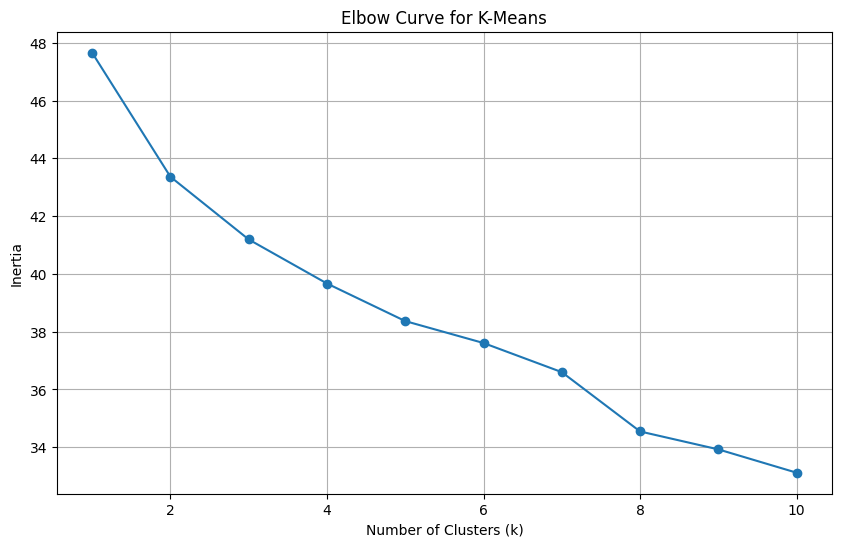

In [32]:
from sklearn.cluster import KMeans

# Elbow Curve to find optimal clusters
inertia_values = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertia_values.append(kmeans.inertia_)

# Plot Elbow Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.title("Elbow Curve for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid()
plt.show()


In [26]:
# K-Means Clustering
num_clusters = 5  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings)

print(f"Cluster Assignments: {clusters}")


Cluster Assignments: [1 2 2 0 3 3 1 0 3 1 1 0 0 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 0 3 3 2 4 1 0 3 1
 0 1 1 1 1 0 0 4 3 3 1 1 3 2 1 0 2 1 1 1 1 0 1 2 3 3 1 4 3 0 2 0 2 1 2 1 0
 1 3 2 3 1 3 1 1 1 1 0 0 0 0 2 1 1 1 3 2 3 1 4 4 1 3]


In [27]:
from sklearn.cluster import AgglomerativeClustering

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
agg_clusters = agg_clustering.fit_predict(embeddings)

print(f"Cluster Assignments (Agglomerative): {agg_clusters}")


Cluster Assignments (Agglomerative): [0 1 1 0 4 4 0 3 1 2 0 3 3 0 1 1 1 2 0 0 0 2 0 0 0 0 2 2 0 1 1 1 4 2 0 1 2
 3 2 0 2 0 0 3 4 4 4 0 0 1 1 2 3 1 0 0 2 0 0 2 1 4 1 0 4 4 0 1 3 1 2 1 0 3
 2 4 1 1 2 4 2 2 0 2 3 0 0 3 1 0 0 2 1 1 4 0 4 4 0 4]


In [28]:
# Evaluate K-Means clustering
kmeans_silhouette = silhouette_score(embeddings, clusters)
kmeans_db = davies_bouldin_score(embeddings, clusters)
kmeans_ch = calinski_harabasz_score(embeddings, clusters)

print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"K-Means Davies-Bouldin Index: {kmeans_db}")
print(f"K-Means Calinski-Harabasz Index: {kmeans_ch}")


K-Means Silhouette Score: 0.06507459282875061
K-Means Davies-Bouldin Index: 2.7531637116486047
K-Means Calinski-Harabasz Index: 5.7521339596725145


In [34]:
# Evaluate Agglomerative Clustering
agg_silhouette = silhouette_score(embeddings, agg_clusters)
agg_db = davies_bouldin_score(embeddings, agg_clusters)
agg_ch = calinski_harabasz_score(embeddings, agg_clusters)

# Print Results

print(f"Agglomerative Silhouette Score: {agg_silhouette}")
print(f"Agglomerative Davies-Bouldin Index: {agg_db}")
print(f"Agglomerative Calinski-Harabasz Index: {agg_ch}")

Agglomerative Silhouette Score: 0.07541341334581375
Agglomerative Davies-Bouldin Index: 2.6903993614645794
Agglomerative Calinski-Harabasz Index: 6.584773934566915


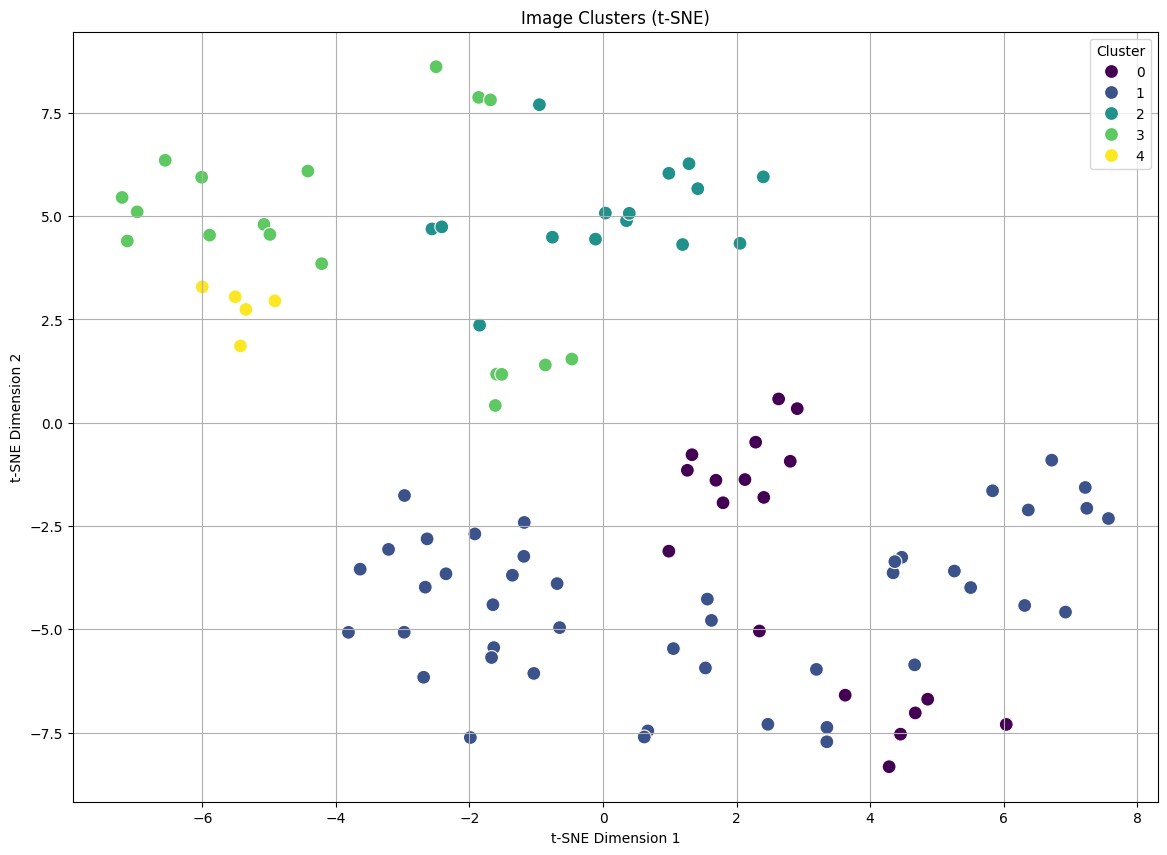

In [29]:
# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot clusters
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=clusters,
    palette="viridis",
    s=100
)
plt.title("Image Clusters (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", loc="best")
plt.grid()
plt.show()


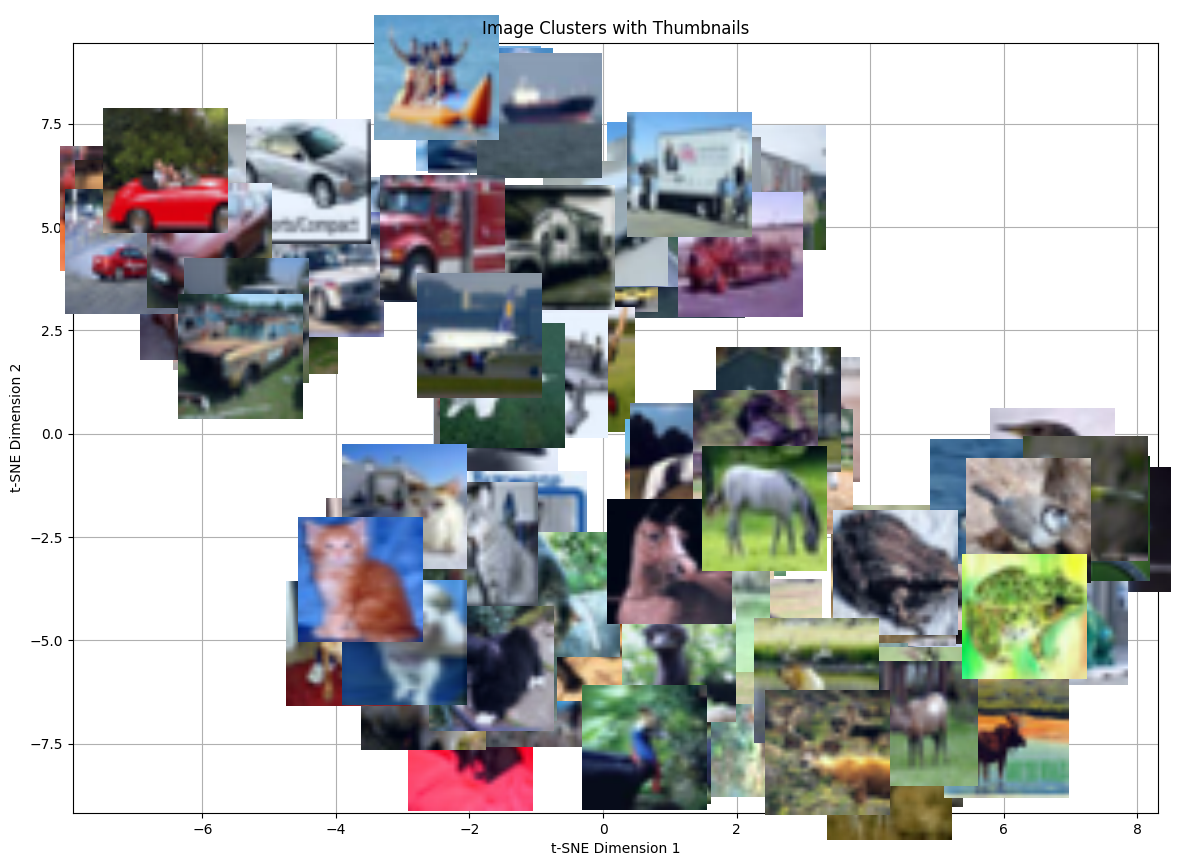

In [30]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Helper function to add image thumbnails to the scatter plot
def plot_with_images(x, y, images, ax=None, zoom=0.5):
    if ax is None:
        ax = plt.gca()
    for x0, y0, img in zip(x, y, images):
        img = transform(img).permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x0, y0), frameon=False)
        ax.add_artist(ab)

# Plot with image thumbnails
fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=100)
plot_with_images(reduced_embeddings[:, 0], reduced_embeddings[:, 1], subset_images, ax=ax, zoom=0.4)
plt.title("Image Clusters with Thumbnails")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()


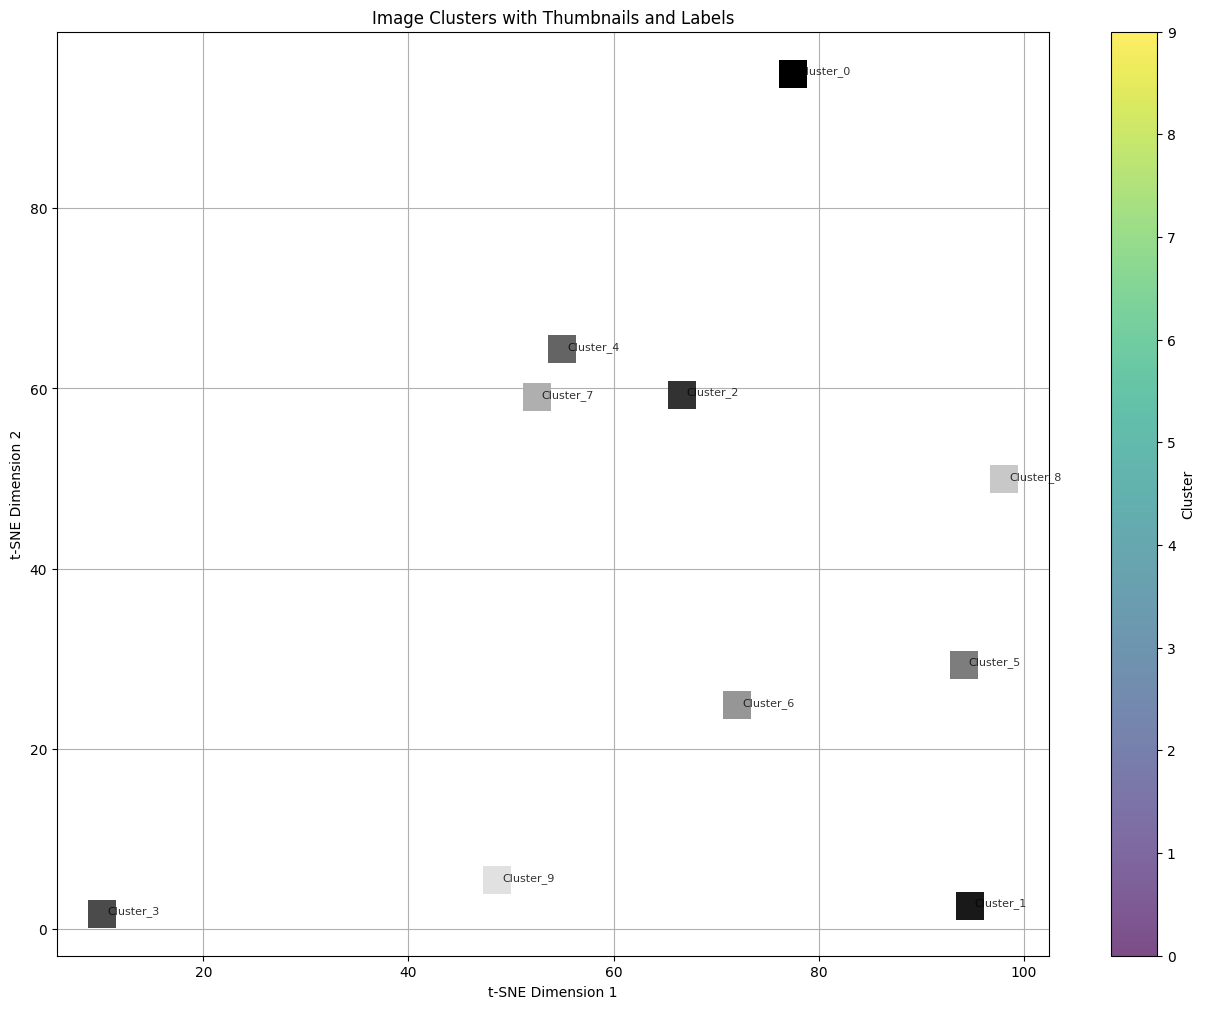

In [31]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Example data: reduced embeddings and images
# reduced_embeddings: 2D array from t-SNE or PCA
# subset_images: Original images (PIL format) corresponding to embeddings
# clusters: Cluster IDs assigned by clustering algorithm

def plot_clusters_with_annotations(embeddings, images, labels, zoom=0.4, figsize=(16, 12)):
    """
    Visualize image clusters with thumbnails and text annotations.

    Args:
        embeddings: 2D array (e.g., t-SNE results) of shape (n_samples, 2).
        images: List of PIL images corresponding to the embeddings.
        labels: List of string labels (e.g., filenames or cluster IDs).
        zoom: Zoom level for image thumbnails.
        figsize: Tuple specifying the figure size.
    """
    # Create the plot
    plt.figure(figsize=figsize)
    ax = plt.gca()

    # Scatter plot for embeddings
    scatter = ax.scatter(
        embeddings[:, 0], embeddings[:, 1],
        c=[int(label.split('_')[-1]) for label in labels],  # Use cluster IDs for coloring
        cmap='viridis', s=100, alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster")

    # Annotate each point with image thumbnails and text labels
    for i, (x, y, img, lbl) in enumerate(zip(embeddings[:, 0], embeddings[:, 1], images, labels)):
        # Add image thumbnail
        imagebox = OffsetImage(np.array(img.resize((50, 50))), zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

        # Add text label
        ax.text(x + 0.5, y, lbl, fontsize=8, alpha=0.8)

    # Customize plot
    plt.title("Image Clusters with Thumbnails and Labels")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid()
    plt.show()

# Example usage with dummy data (replace with actual t-SNE and images)
reduced_embeddings = np.random.rand(10, 2) * 100  # Example t-SNE results
subset_images = [Image.new('RGB', (100, 100), (i*25, i*25, i*25)) for i in range(10)]  # Dummy grayscale images
labels = [f"Cluster_{i}" for i in range(10)]  # Example cluster labels

plot_clusters_with_annotations(reduced_embeddings, subset_images, labels)


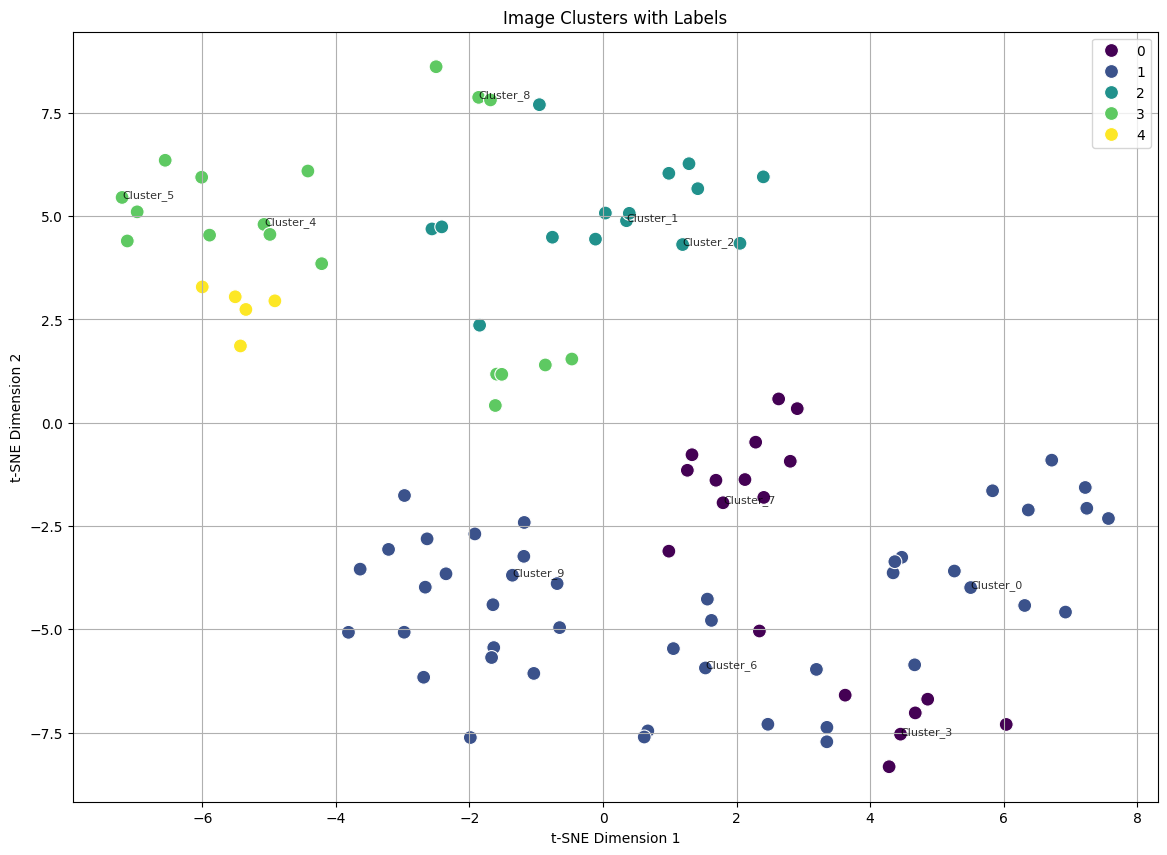

In [36]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot clusters with names
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=clusters,
    palette="viridis",
    s=100
)

# Annotate with document/image names
for i, label in enumerate(labels):
    plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.8)

plt.title("Image Clusters with Labels")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid()
plt.show()


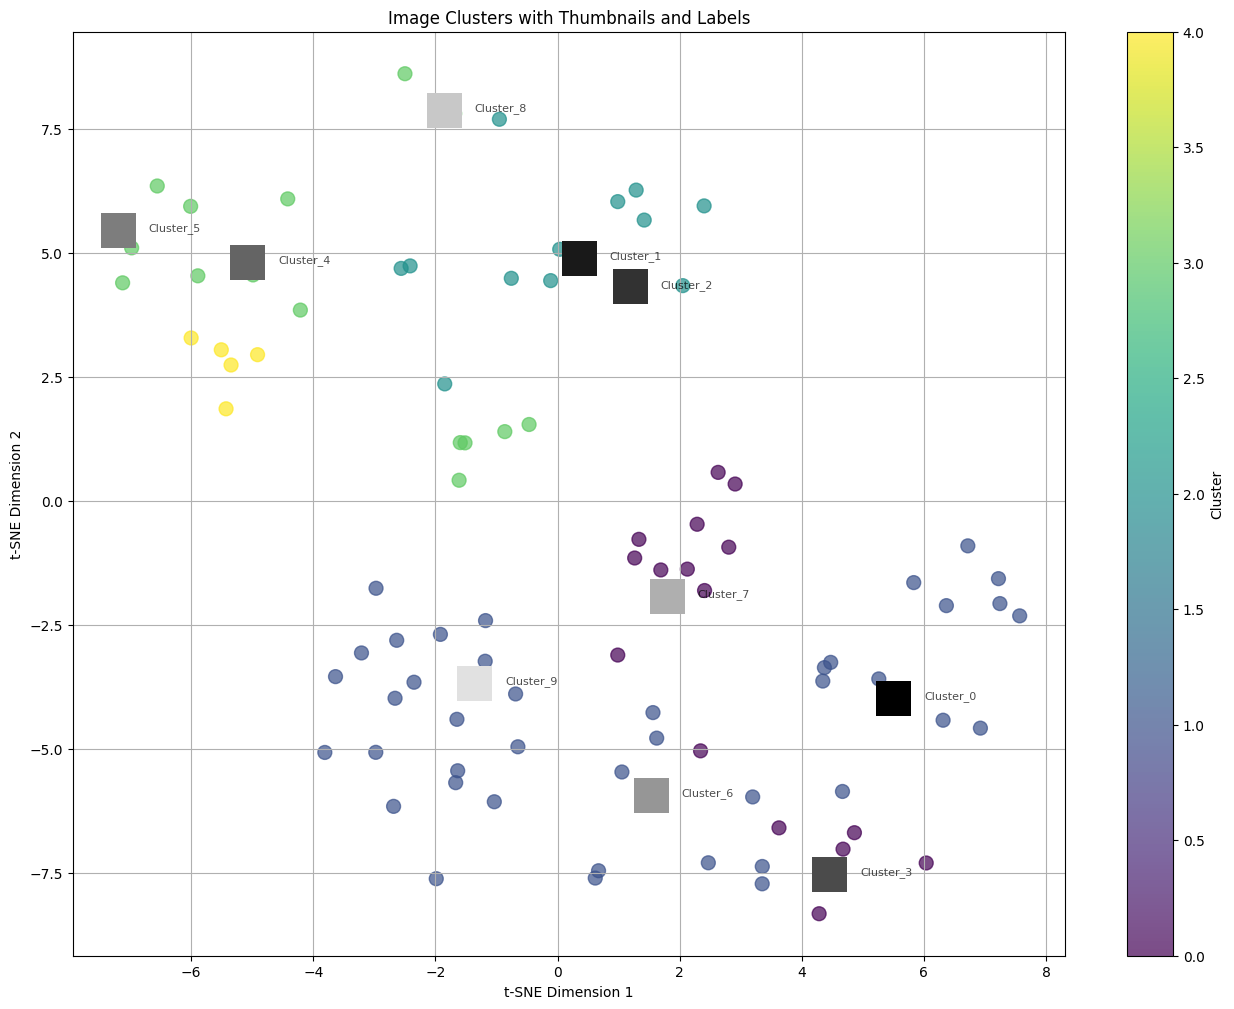

In [40]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_with_thumbnails(embeddings, images, labels, zoom=0.5, figsize=(16, 12)):
    fig, ax = plt.subplots(figsize=figsize)

    # Scatter plot
    scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap='viridis', s=100, alpha=0.7)
    plt.colorbar(scatter, ax=ax, label="Cluster")

    # Add image thumbnails
    for i, (x, y, img) in enumerate(zip(embeddings[:, 0], embeddings[:, 1], images)):
        imagebox = OffsetImage(np.array(img.resize((50, 50))), zoom=zoom)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    # Add text annotations
    for i, (x, y, label) in enumerate(zip(embeddings[:, 0], embeddings[:, 1], labels)):
        ax.text(x + 0.5, y, label, fontsize=8, alpha=0.7)

    # Customize plot
    plt.title("Image Clusters with Thumbnails and Labels")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid()
    plt.show()

# Visualize
plot_with_thumbnails(reduced_embeddings, subset_images, labels)


In [41]:
for i, (x, y, label) in enumerate(zip(reduced_embeddings[:, 0], reduced_embeddings[:, 1], clusters)):
    ax.text(x + 1, y, f"Cluster {label}", fontsize=8, alpha=0.8)


In [42]:
!pip install plotly


In [44]:
import pandas as pd
import plotly.express as px
tsne_df = pd.DataFrame({
    'x': reduced_embeddings[:, 0],
    'y': reduced_embeddings[:, 1],
    'Cluster': clusters
})

fig = px.scatter(tsne_df, x='x', y='y', color='Cluster', title="Interactive Clusters")
fig.show()
